In [5]:
from sklearn.preprocessing import normalize
import json
import msacorrnet as mcn
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import matplotlib.cm as cm
from scipy.spatial import distance
import random
import matplotlib as mpl

In [6]:
time = int(9000)

file = "data/cp-rh-varying-3hr/cpu_usage.json"

f = open(file)

data = json.load(f)
f.close()

f_dict = {}
data = data['data']['result']
for ent in range(len(data)):
    if data[ent]['metric']['id'] != "/":
        f_dict[data[ent]['metric']['pod']] = np.zeros((len(data[ent]['values']), 2))
        f_dict[data[ent]['metric']['pod']][:, 0] = [float(x[0]) for x in data[ent]['values']]
        f_dict[data[ent]['metric']['pod']][:, 1] = [float(x[1]) for x in data[ent]['values']]

for service in f_dict:
    if data[0]["metric"]["__name__"] == "container_memory_usage_bytes":
        pass
    else:
        temp = [0]
        for i in range(1, np.shape(f_dict[service])[0]):
            temp.append(f_dict[service][i, 1] - f_dict[service][i - 1, 1])
        f_dict[service][:, 1] = deepcopy(temp)
        f_dict[service][:, 1] = mcn.sub_sample_zeros(f_dict[service][:, 1])

max_len = 0
for i in f_dict:
    if len(f_dict[i]) > max_len:
        max_len = len(f_dict[i])

aligned_data = mcn.align_data(f_dict, 5, time)
service_list = []
for s in aligned_data:
    service_list.append(s)
s_list = []
for s in aligned_data:
    s_list.append(s)
X = np.zeros((int((time / 5) ), len(s_list)))
ind = 0
for s in service_list:
    X[:, ind] = aligned_data[s][:, 1]
    ind += 1

In [7]:
import fnmatch
misc_ms = ["nginx*","jaeger*"]
for ms in misc_ms:
    matched_indices = [index for index, string in enumerate(service_list) if fnmatch.fnmatchcase(string, ms)]
    if len(matched_indices) > 0:
        s_list.pop(matched_indices[0])
        service_list.pop(matched_indices[0])
        X = np.delete(X,matched_indices[0],axis=1)

In [8]:
win = 360
step = 1
Xc = deepcopy(X)
Xdiff = np.diff(Xc,axis=0)
Xdiff = normalize(Xdiff,axis=0)
r_dict = mcn.rolling_window(Xdiff[:,:], win, "tapered", step, 0.3, "tmfg", "pearsons")

D:\Documents\PhD\Code\MSACorrNet-INFOCOM-2025\msacorrnet.py:57: RuntimeWarning: invalid value encountered in true_divide
  R = temp / np.sqrt(np.dot(R, R.T))


In [9]:
r_pos = {}
for corr in r_dict:
    r_pos[corr]=deepcopy(r_dict[corr])
    r_pos[corr] += 1
    
spectra = mcn.all_spectra(r_pos, True)
all_es = spectra.T
all_es = all_es[:,:-1]

In [10]:
scaling="LMDS"
if scaling == "LMDS":
    landmarks = random.sample(range(0, all_es.shape[0], 1), int(len(all_es) / 4))
    dist = distance.cdist(all_es[landmarks, :], all_es, 'euclidean')
    coords = mcn.LMDS(dist, landmarks, 2)

elif scaling == "MDS":
    dist = distance.cdist(all_es, all_es, 'euclidean')
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
    coords = mds.fit_transform(dist)

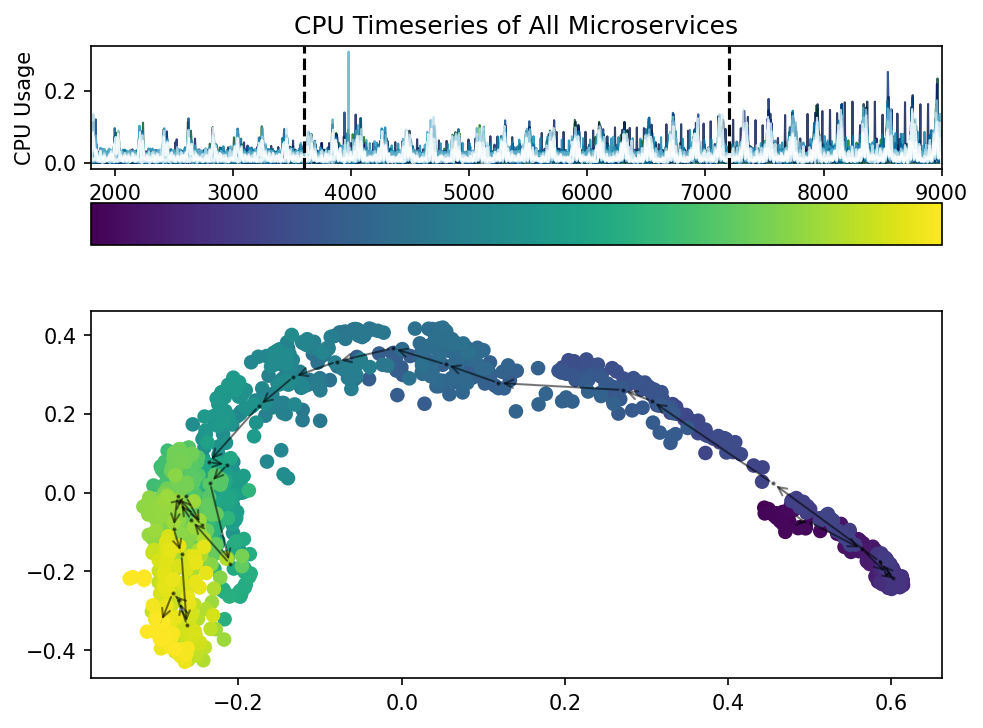

In [11]:
# Finalized plot
fig, ax = plt.subplot_mosaic('AAA;BBB;CCC', gridspec_kw=dict(
    height_ratios=[1, 0.1, 3]), dpi=150)

n = len(r_pos)
cmap_type = "viridis"
type_color = "ocean"
cmap = cm.get_cmap(type_color, n)
t = np.arange(0, n)
plt.tight_layout()
fin = int(np.floor(len(X)/step)*step)
ax['A'].set_ylabel('CPU Usage')
ax['A'].set_title('CPU Timeseries of All Microservices')
ax['A'].set_xlabel("Time (s)")
ax['A'].plot(range(win*5,len(Xc)*5,5),normalize(Xc[win:,:]*100,axis=0), alpha=0.8, linewidth=1)

# ax['A'].set_ylim(ymax=300)
ax['A'].set_xlim(xmin=win*5)
ax['A'].set_xlim(xmax=len(X)*5)
cmap = cm.get_cmap(type_color, np.shape(X)[1])
colors = [cmap(i) for i in range(np.shape(X)[1])]
for i, j in enumerate(ax['A'].lines):
    j.set_color(colors[i])

ax['A'].axvline((3600), color='k',linestyle='--')
ax['A'].axvline((7200), color='k',linestyle='--')

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(int(win*5), time),
                                          cmap=cmap_type),
                    ax=ax['B'],
                    orientation='horizontal',
                    fraction=3.5,
                    pad=0,
                    )
ax['B'].set_visible(False)

cbar.ax.tick_params(size=0)
cbar.set_ticks([])

ax['C'].scatter(coords[:, 0], coords[:, 1], c=t, cmap=cmap_type, alpha=1)

n_pts = 50
if n_pts > 0:
    prev_x = np.mean(coords[0:n_pts, 0])
    prev_y = np.mean(coords[0:n_pts, 1])
    for i in range(10, len(coords), n_pts):
        curr_x = np.mean(coords[i:i+n_pts, 0])
        curr_y = np.mean(coords[i:i+n_pts, 1])
        ax['C'].plot([prev_x, curr_x], [prev_y, curr_y], 'k', alpha=0.5, linewidth=0.1)
        ax['C'].plot(prev_x, prev_y, 'k.', markersize=2, alpha=0.5)
        ax['C'].annotate("",
                              xytext=(prev_x, prev_y),
                              xy=(curr_x, curr_y),
                              arrowprops=dict(arrowstyle="->", color='k', alpha=0.5, linewidth=1))
        prev_x = curr_x
        prev_y = curr_y


plt.show()